# Convolutional LSTM Model

### Install all the necessary python packages

In [1]:
!pip install pafy youtube-dl moviepy
!pip install opencv-python
!pip install tensorflow
!pip install matplotlib
!pip install scikit-learn
!pip install scipy

### Import all necessary libraries

In [1]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from moviepy.editor import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

### Set the seed constant

The seed value is used to generate the random number generator. And, every time you use the same seed value, you will get the same random values.

In [7]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

### Get the names of all classes in dataset

In [8]:
all_classes_names = os.listdir('GMS')

### Visualize a random sample videos from the dataset for each category

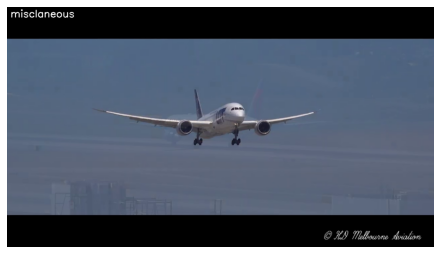

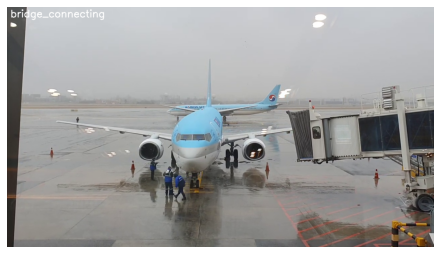

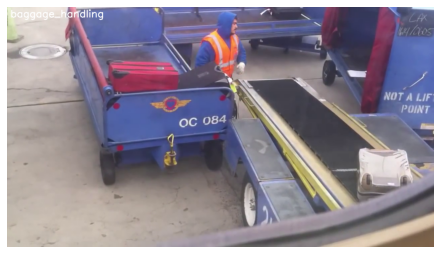

In [9]:
random_range = random.sample(range(len(all_classes_names)), 3)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):
    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'GMS/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'GMS/{selected_class_Name}/{selected_video_file_name}')

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    # Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Display the frame.
    plt.figure(figsize=(15, 15))
    plt.subplot(3, 1, counter);
    plt.imshow(rgb_frame);
    plt.axis('off')

### Data Preprocessing

Since we are going to use a classification architecture to train on a video classification dataset, we need to preprocess the dataset first.

This is the size we will resize all frames of the video to, we are doing this to avoid unnecessary computation.

In [10]:
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64

Specify the number of frames of a video that will be fed to the model as one sequence.

In [11]:
SEQUENCE_LENGTH = 20

The path of the directory containing the extracted dataset.

In [12]:
DATASET_DIR = "GMS"

Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.

In [13]:
CLASSES_LIST = ["bridge_connecting", "baggage_handling", "misclaneous"]

This "frames_extraction" function will extract the required frames from a video after resizing and normalizing them. It takes path of the video in the disk as input, whose frames are to be extracted. It returns a list containing the resized and normalized frames of the video.

In [14]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list

This "create_dataset" function will extract the data of the selected classes and create the required dataset. It return a list containing the extracted frames of the videos, list containing the indexes of the classes associated with the videos, and list containing the paths of the videos in the disk.

In [15]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:
                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

Create the dataset by calling "create_dataset" function.

In [16]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: bridge_connecting
Extracting Data of Class: baggage_handling
Extracting Data of Class: misclaneous


Now we will convert class labels to one hot encoded vectors using kera's to_categorical method.

In [19]:
one_hot_encoded_labels = to_categorical(labels)

### Split the Data into Train and Test Sets

Now we have two numpy arrays, one containing all images. The second one contains all class labels in one hot encoded format. Let us split our data to create a training, and a testing set. We must shuffle the data before the split, which we have already done.

In [20]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25, shuffle = True, random_state = seed_constant)

### Define the model

Let's create a "create_convlstm_model" function that will construct our model. Here, we will be using sequential model for model construction. 

### Model Architecture:

4 ConvLSTM cells are being used. We use Keras convLSTM2D recurrent layers to construct the model. This convLSTM2D layer takes number of filters and kernel size as input for performing convolutional operations. MaxPooling3D layers to reduce the dimensions of the frames and avoid unnecessary computations. We apply a Time distributed layer to every temporal slice of an input. Every input should be at least 3D, and the dimension of index one of the first input will be considered to be the temporal dimension. For example, your data is 5-dim with (sample, time, width, length, channel) you could apply a convolutional layer using TimeDistributed (which is applicable to 4-dim with (sample, width, length, channel)) along a time dimension (applying the same layer to each time slice) in order to obtain 5-d output. The dropout layers are added at each layer to prevent the overfitting problem. The output layer is flattened and fed to the Dense layer with softmax as an activation which outputs the probability of each action category. 

In [21]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(ConvLSTM2D(filters=4, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape=(SEQUENCE_LENGTH,
                                                                                    IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters=8, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters=14, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    # model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation="softmax"))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed convlstm model.
    return model

Construct the required convlstm model by calling "create_convlstm_model" function:

In [22]:
convlstm_model = create_convlstm_model()
# Display the success message.
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 31, 31, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 31, 31, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                        

Using the plot_model function, we can check the structure of the final model. This is really helpful when we are creating a complex network, and you want to make sure we have constructed the network correctly.

In [23]:
# plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

Create an Instance of Early Stopping Callback:

In [24]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

Compile the model and specify loss function, optimizer and metrics values to the model

In [25]:
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

### Model Training

In [26]:
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4,shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/50
28/28 [==============================] - 34s 951ms/step - loss: 1.0046 - accuracy: 0.4685 - val_loss: 0.7885 - val_accuracy: 0.6429
Epoch 2/50
28/28 [==============================] - 26s 940ms/step - loss: 0.6505 - accuracy: 0.7748 - val_loss: 0.5626 - val_accuracy: 0.8571
Epoch 3/50
28/28 [==============================] - 27s 960ms/step - loss: 0.4950 - accuracy: 0.8018 - val_loss: 0.5553 - val_accuracy: 0.7857
Epoch 4/50
28/28 [==============================] - 27s 964ms/step - loss: 0.4969 - accuracy: 0.8018 - val_loss: 0.4209 - val_accuracy: 0.8571
Epoch 5/50
28/28 [==============================] - 28s 1s/step - loss: 0.4379 - accuracy: 0.8378 - val_loss: 0.5260 - val_accuracy: 0.7857
Epoch 6/50
28/28 [==============================] - 30s 1s/step - loss: 0.4536 - accuracy: 0.8198 - val_loss: 0.4990 - val_accuracy: 0.8571
Epoch 7/50
28/28 [==============================] - 30s 1s/step - loss: 0.4104 - accuracy: 0.8468 - val_loss: 0.4498 - val_accuracy: 0.8571
Epoch 8/

### Model Evaluation

In [27]:
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

2/2 [==============================] - 6s 864ms/step - loss: 0.4736 - accuracy: 0.8085


Get the loss and accuracy from model_evaluation_history:

In [28]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

You should now save your model for future runs.

In [29]:
# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save your Model.
convlstm_model.save(model_file_name)

### Model Inference

The "plot_metric" method get metrics value using metric names as identifiers and constructs a range object which will be used as time. This function plots the graph, adds title, and legend.

In [30]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label=metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

Visualize the training and validation loss metrices:

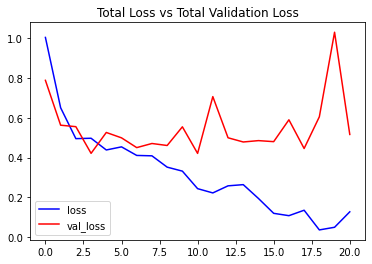

In [31]:
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

Visualize the training and validation accuracy metrices.

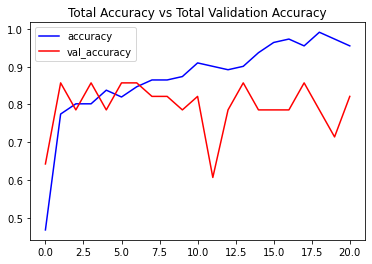

In [32]:
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')